In [13]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

(9999, 785)

In [ ]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")

In [16]:
# from small MNIST dataset
#tsne = TSNE(n_components = 2, random_state=0).fit_transform(train)

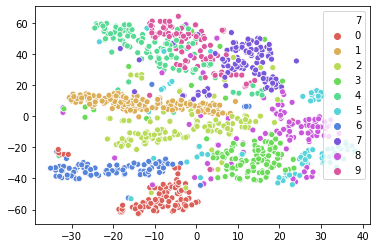

In [18]:
#sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

### Testing our Algorithm (unoptimized)

In [36]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

iris = sns.load_dataset('iris')

# matrix data
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
specs = np.array(iris['species'])

def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows.
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D


def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""

    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond + 1e-10) / (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])

    return P_cond


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.

    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid


def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis=1)
    perplexity = 2 ** entropy

    return perplexity


def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i + 1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""

    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)

    # q_i|i = 0
    np.fill_diagonal(Q, 0.)

    return Q


def p_ij(X, target_perplexity):
    """Calculate joint probabilities in the high dimensional space given data matrix X
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)

    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)

    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)

    # convert conditional P to joint P matrix (pg. 2584)
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)

    return p_joint


def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P - Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]

    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis=1)

    return grad


def tsne_opt(X, num_iters=1000, perplexity=30, alpha=10, momentum=0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.

    Inputs:
        X: data matrix
        num_iters: number of iterations
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm
    """

    # Initialize Y
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])

    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):
        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - alpha * grad) + (momentum * (Y_tmin1 - Y_tmin2))

        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y
        
        if (i+ 1) % 10 == 0:
            print("Iteration %d" % (i + 1))

    return Y



In [21]:
yout = tsne_opt(train)


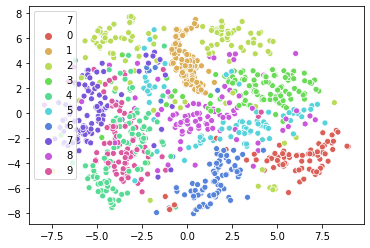

In [27]:
sns.scatterplot(yout[:,0], yout[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full')

#### Testing Paper Algorithm

In [29]:
#laurens

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y




Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.541512
Iteration 20: error is 20.975234
Iteration 30: error is 18.103656
Iteration 40: error is 16.880801
Iteration 50: error is 16.476015
Iteration 60: error is 16.257444
Iteration 70: error is 16.178976
Iteration 80: error is 16.102817
Iteration 90: error is 16.053010
Iteration 100: error is 16.006372
Iteration 110: error is 2.334313
Iteration 120: error is 2.092274
Iteration 130: error is 1.907063
Iteration 140: error is 1.767791
Iteration 150: error is 1.660149
Iteration 160: error is 1.575339
Iteration 170: error is 1.507591
Iteration 180: error is 1.452288
Iteration 190: error is 1.406424
Iteration 200: error is 1.367891
Iteration 210: error

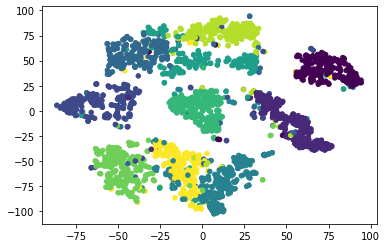

In [32]:
X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
pylab.show()

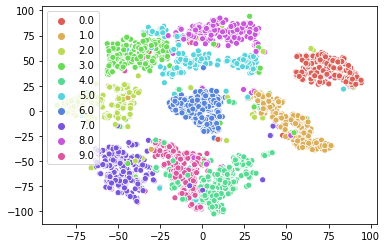

In [33]:
sns.scatterplot(Y[:,0], Y[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full')

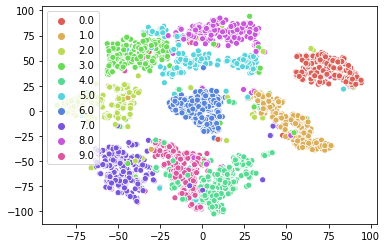

In [35]:
plot_lauren = sns.scatterplot(Y[:,0], Y[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full').get_figure()
plot_lauren.savefig("paper_MNIST_plot.png")

In [41]:
yout = tsne_opt(X)

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Iteration 720
I

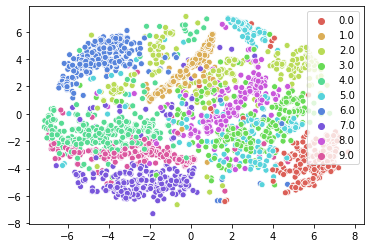

In [42]:
sns.scatterplot(yout[:,0], yout[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full')

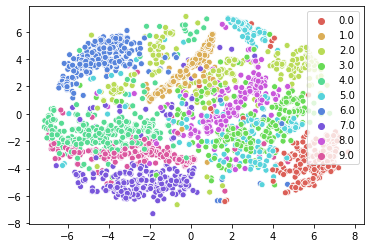

In [43]:
plot_ours = sns.scatterplot(yout[:,0], yout[:,1], hue = labels, palette = sns.hls_palette(10), legend = 'full').get_figure()
plot_ours.savefig("our_MNIST_plot.png")